# 9. Feature subset selection

In [1]:
%matplotlib inline
import warnings;warnings.filterwarnings('ignore');import matplotlib.pyplot as plt;import numpy as np;import pandas as pd;import seaborn as sns;sns.set_context("notebook", font_scale=1.4);sns.set_style("whitegrid");import imp;compomics_import = imp.load_source('compomics_import', '../compomics_import.py');from IPython.core.display import HTML;css_file = '../my.css';HTML(open(css_file, "r").read())

Another way to reduce the dimensionality of a data set is through **feature subset selection (FSS)** (or **feature selection**). FSS is the process of selecting the **subset of relevant features** for use in model construction. Many flavors exist such as selecting the minimal subset of relevant feature for which leaving one feature out will have a serious impact on the performance of a model. Or one might be interested in the maximal subset that might contain redundant relevant features as well. Knowing which features are relevant for a certain task and which 
ones are not often provides useful knowledge about the task, something that is much harder to obtain when applying feature extraction. For instance in a microarray data set where the features are genes it can be useful to know which subset of the features is sufficient to accurately solve a certain task. 

The key idea behind FSS is rather simple: define a score $s(F)$ that estimates the relevance of a feature subset $F$ for the task and then find $F$ that optimizes $s(F)$ (for convenience we associate high score $s(F)$ to indicate high relevance of the subset $F$). If there are few features in a data set then one could consider all possible feature subsets to find the best one. However for real world prediction tasks with many features this is computationally not feasible. Instead, we have seen that **greedy search algorithms** (such as gradient descent or decision tree learning) can provide a "good enough" solution in this case. For instance we can start with the feature subset that contains all the features and iteratively remove features from the subset based on the score $s(F)$ for each resulting feature subset $F$. This is known as **sequential backward selection** and works as follows.

1. Let $F$ be the subset that contains all the features.
2. Consider each feature $x^{(i)}$ ($i=1 \ldots m$) in $F$ and compute the score $s(F_i)$ with $F_i = F \setminus x^{(i)}.$
3. Set $F = F_i$ with $$i = \underset{i}{\operatorname{argmax}}  s(F_i).$$
4. Repeat step 3. until the score starts to decrease significantly.

Here $m$ is the number of features in the data set. Alternatively we can start with the empty feature subset and iteratively add features from the subset based on the score $s(F)$ for each resulting feature subset $F$. This is known as **sequential forward selection**. In general forward selection will work best for tasks with few relevant features as it evaluates more candidate feature subsets when $F$ is small. When the task requires many relevant features to obtain accurate generalization performance then forward selection might not be able to find the relevant features when $F$ is still small. Backward selection solves this by exploring more subsets when $F$ is still large such that relevant feature interactions ca be detected at the beginning of the search. Both search algorithms suffer from the fact that the relevance of a feature cannot be reevaluated when it was added or removed. Many search algorithms exist that can (partly) overcome this limitation such as simulated annealing that mimics the slow cooling of a solid or genetic algorithms that mimic the process of natural selection.

We can partition FSS algorithms into roughly 2 main types: **filter** and **wrapper approaches**. Filter approaches compute feature relevance directly from a data set. Typically the relevance of each feature for the task is computed **independently** from the other features. For instance we can compute the correlation coefficient between a feature and the label. High correlation indicates strong relevance to the task of predicting the label. Or we can compute the information gain (as in decision trees) for each feature and use this as an estimate for feature relevance. Many such filters provide a **feature ranking** rather than an explicit best feature subset. In this case we can apply cross-validation to find a good ranking threshold point to select the best feature subset. 

A popular feature relevance estimator for gene expression classification tasks is the ANOVA F-test (Student's t-test for two classes) that, for a feature $x^{(i)}$, tests if the distribution of the values for $x^{(i)}$ differ (low $p$-values) for one of the groups. Let's load a gene expression data set obtained from the [Expression Project for Oncology (expO)](http://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE2109). The goal of expO and its consortium supporters is to procure tissue samples under standard conditions (Affymetrix Human Genome U133 Plus 2.0 Array) and perform gene expression analyses on a clinically annotated set of deidentified tumor samples. The data set contains 120 tumor samples that are represented by 1000 preprocessed gene expression readouts. There are 60 samples annotated as endometrium cancer and 60 as ovary cancer.

In [2]:
dataset = pd.read_csv("Endometrium_Ovary.csv")
print dataset.shape
dataset.label.value_counts()

(120, 1001)


1    60
0    60
Name: label, dtype: int64

We split the data set into a train set that will be used for feature subset selection and a test set to evaluate the generalization performance of the subset.

In [3]:
np.random.seed(123)
folds = np.random.randint(0,2,len(dataset))

In scikit-learn there is a module `feature_selection` that implements several feature subset selection approaches. One of them is `f_classify()` that computes the ANOVA F-statistic and corresponding $p$-value for each feature: 

In [4]:
from sklearn import feature_selection

dataset_cols = dataset.columns.values
X = dataset[folds==0].copy()
y = X.pop('label')

(F,pval) = feature_selection.f_classif(X,y)

F_rank = sorted(range(len(F)), key=lambda k: F[k],reverse=True)

for i,feature in enumerate(F_rank[0:10]):
    print "%i %s (%f)" % (i+1,dataset_cols[feature],F[feature])

1 213707_s_at (68.312611)
2 206893_at (62.667316)
3 217073_x_at (55.958325)
4 229273_at (53.804511)
5 226492_at (52.647327)
6 209710_at (51.982138)
7 214844_s_at (45.299197)
8 228335_at (44.507874)
9 219873_at (43.886193)
10 203876_s_at (43.348985)


We now obtained a ranking of the features. To find a good feature subset from this ranking we can compute the CV-score for a learning algorithm (here we use a SVM) for the top $k$ ranked features and search for $k$ with the highest CV-score measured as AUC.

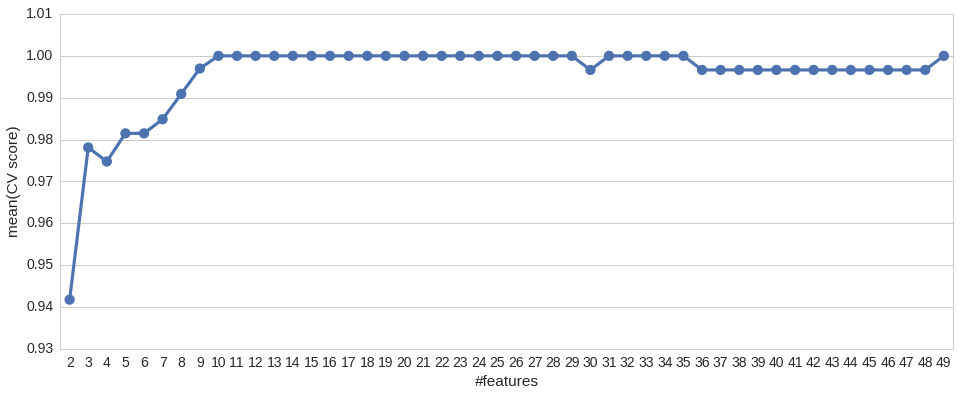

In [5]:
from sklearn.cross_validation import cross_val_score
from sklearn.svm import SVC

svc = SVC(kernel="linear",C=0.01)

cv_scores = []
for k in range(2,50):
    X = dataset[folds==0][F_rank[0:k]]
    cv_scores.append(cross_val_score(svc, X, y, scoring='roc_auc').mean())
    
pd_cv_scores = pd.DataFrame()
pd_cv_scores['#features'] = range(2,50)
pd_cv_scores['CV score'] = cv_scores

plt.figure(figsize=(16,6))
sns.pointplot(x="#features", y="CV score", data=pd_cv_scores)
plt.show()

The plot shows that for a feature subset with the top-2 features selected by ANOVA the AUC is already larger than 95%.
Adding the most relevant features to the data set significantly increases the CV-score up until about 13 features. Here's how a SVM model trained on the top-2 and top-13 ANOVA ranked features performs on the test set:

In [6]:
from sklearn.metrics import roc_auc_score

X = dataset.copy()
y = X.pop('label')

for k in [2,13]:
    Xtrain = X[folds==0][F_rank[0:k]]
    Xtest = X[folds==1][F_rank[0:k]]
    svc.fit(Xtrain,y[folds==0])
    print "AUC on test set (top-%i): %.2f" % (k,roc_auc_score(y[folds==1],svc.decision_function(Xtest)))

AUC on test set (top-2): 0.86
AUC on test set (top-13): 0.93


The generalization performance estimated on the test set is significantly lower than estimated by the CV-score on the train. This indicates overfitting and will be addressed further in this chapter.

Filters are usually not computationally intensive, but they produce a feature ranking which is not tuned to a specific type of predictive model (such as the SVM employed above). Wrapper methods use a predictive model directly to compute $s(F)$. For instance in the case of SVM we can exploit the model parameters $\theta$ as they should estimate some measure of relevance of the features. For linear models we know that these parameters are weights for the features, i.e. they weigh the contribution of each feature to the decision boundary. We can thus assume that features $x^{(i)}$ with weights $\theta_i$ close to zero can be considered less relevant for the task than features with a weight far from zero. We can exploit this idea to construct the following backward sequential feature selection algorithm.

1. Let $F$ be the subset that contains all the features.
2. Compute a linear model using $F$.
3. Remove the features $x^{(i)}$ with the lowest $abs(\theta_i)$.
4. Repeat step 2. and 3. until the performance on a validation starts to decrease significantly.

This feature selection algorithm (known as **Recursive Feature Elimination (RFE)**) also only produces a feature ranking: the last feature that was removed gets rank 1, the feature removed just before that gets rank 2, etc. In scikit-learn we can use the `RFE` module in the `feature_selection` package to compute this ranking on the train set:

In [7]:
from sklearn.feature_selection import RFE

X = dataset[folds==0].copy()
y = X.pop('label')

svc = SVC(kernel="linear",C=0.01)
rfe = RFE(estimator=svc, step=1,n_features_to_select=1)
rfe.fit(X, y)

ranked_features = compomics_import.convert_ranking(rfe.ranking_)
svm_rank = dataset_cols[ranked_features]
for p1,p2 in zip(svm_rank[0:10],dataset_cols[F_rank[0:10]]):
    print "%s %s" % (p1,p2)

209710_at 213707_s_at
226492_at 206893_at
217073_x_at 217073_x_at
226066_at 229273_at
228528_at 226492_at
228335_at 209710_at
218358_at 214844_s_at
219873_at 228335_at
235142_at 219873_at
203876_s_at 203876_s_at


We now again obtained a ranking of the features that can be evaluated using CV: 

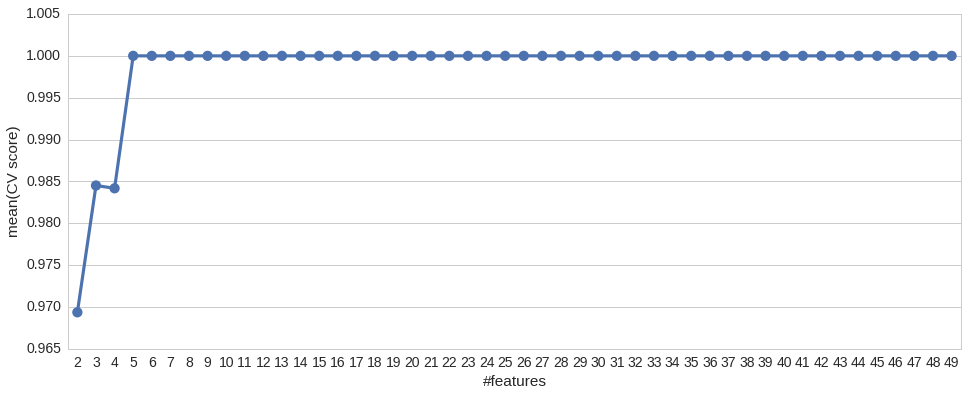

In [8]:
from sklearn.cross_validation import cross_val_score

cv_scores = []
for k in range(2,50):
    X = dataset[folds==0][svm_rank[0:k]]
    cv_scores.append(cross_val_score(svc, X, y, scoring="roc_auc").mean())
    
pd_cv_scores = pd.DataFrame()
pd_cv_scores['#features'] = range(2,50)
pd_cv_scores['CV score'] = cv_scores

plt.figure(figsize=(16,6))
sns.pointplot(x="#features", y="CV score", data=pd_cv_scores)
plt.show()

We observe how this ranking allows for finding a much smaller feature subset that obtains a much better CV-score, in fact using only the top-6 ranked features the CV-score estimate a perfect classification. There is however a problem with this approach. Just as with the ANOVA ranking we used the train set to compute the feature ranking. We then used CV on the same train set to find the optimal feature subset. So, each test set in the CV folds **has been seen before** by the RFE (or ANOVA) strategy to compute the ranking. To illustrate that this is indeed an issue we use the same RFE feature ranking to evaluate the performance of the top ranked features when training on the train set and testing on the test set:

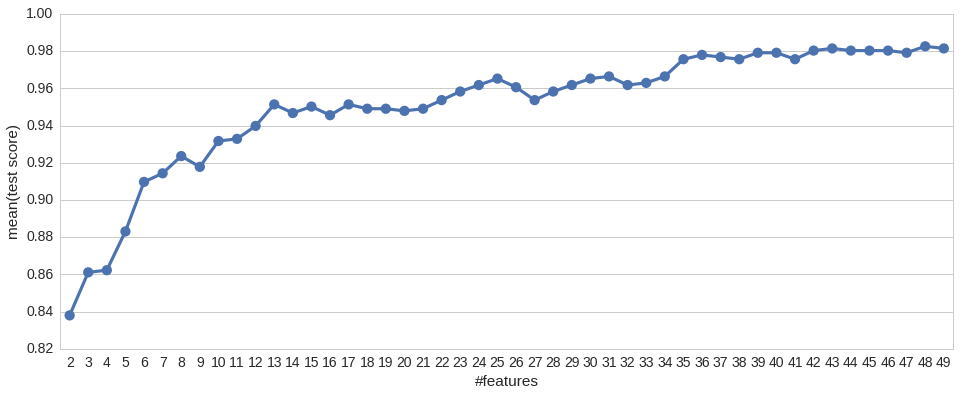

In [9]:
X = dataset.copy()
y = X.pop('label')

Xtrain = X[folds==0]
Xtest = X[folds==1]
ytrain = y[folds==0]
ytest = y[folds==1]

test_scores = []
for k in range(2,50):
    svc.fit(Xtrain[svm_rank[0:k]],ytrain)
    test_scores.append(roc_auc_score(ytest,svc.decision_function(Xtest[svm_rank[0:k]])))
    
pd_test_scores = pd.DataFrame()
pd_test_scores['#features'] = range(2,50)
pd_test_scores['test score'] = test_scores

plt.figure(figsize=(16,6))
sns.pointplot(x="#features", y="test score", data=pd_test_scores)
plt.show()

Now we see that we actually need many more features to obtain good generalization performance. This example clearly shows that selecting the optimal number of relevant features using CV on the train set used to compute feature ranking is a bad idea. Instead, to evaluate the feature selection performance, one should split the data set into a train set to perform RFE, a validation set to select the optimal number of features, and a test set to evaluate the performance of the model trained on the data set that consists of both the train and the validation set using the selected feature subset:

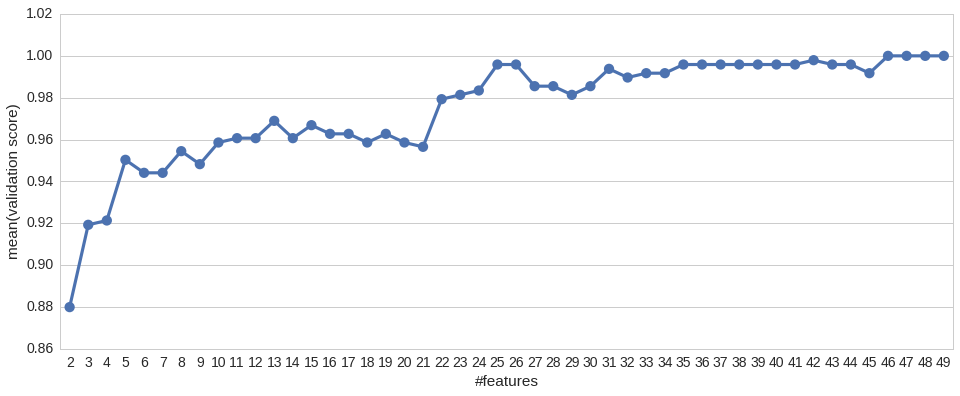

In [10]:
X = dataset.copy()
y = X.pop('label')

np.random.seed(123)
folds = np.random.randint(0,3,len(dataset))

Xtrain = X[folds==0]
Xtest = X[folds==1]
Xval = X[folds==2]
ytrain = y[folds==0]
ytest = y[folds==1]
yval = y[folds==2]

rfe.fit(Xtrain, ytrain)

ranked_features_train = compomics_import.convert_ranking(rfe.ranking_)
svm_rank_train = dataset_cols[ranked_features]

validation_scores = []
for k in range(2,50):
    svc.fit(Xtrain[svm_rank_train[0:k]],ytrain)
    validation_scores.append(roc_auc_score(yval,svc.decision_function(Xval[svm_rank[0:k]])))
    
pd_val_scores = pd.DataFrame()
pd_val_scores['#features'] = range(2,50)
pd_val_scores['validation score'] = validation_scores

plt.figure(figsize=(16,6))
sns.pointplot(x="#features", y="validation score", data=pd_val_scores)
plt.show()

From the AUC results on the validation set we can conclude that selecting the top-5 ranked feature will provide good generalization performance. However, if we want better performance we need to select the top-25 ranked features. Let's see if this matches what we observe for the test set:

In [11]:
X = dataset.copy()
y = X.pop('label')

Xtrain = X[folds!=2]
ytrain = y[folds!=2]

for k in [5,25]:
    svc.fit(Xtrain[svm_rank_train[0:k]],ytrain)
    print "AUC on test set (top-%i): %.2f" % (k,roc_auc_score(ytest,svc.decision_function(Xtest[svm_rank_train[0:k]])))

AUC on test set (top-5): 0.93
AUC on test set (top-25): 0.99


These AUC values provide a good estimation of the generalization performance of a SVM model using the top-5 and top-25 RFE ranked features. From the validation we already estimated that the top-25 features would perform much better than the top-5 features.

The random forest algorithm can also be used to compute a feature relevance ranking for finding the optimal feature subset. For instance the relative rank (i.e. depth) of a feature used as a decision node in a decision tree can be used to assess the relative importance of that feature with respect to the predictability of the target. Features used at the top of the tree contribute to the final prediction decision of a larger fraction of the input samples. The expected fraction of the samples they contribute to can thus be used as an estimate of the relative importance of the features. For the Random Forests algorithm we can average those **expected activity rates** over several randomized trees to reduce the variance of such an estimate and use it for feature ranking. The `RandomForestClassifier` module in scikit-learn has a property `feature_importances_` that contains these average expected activity rates for the features in the data set: 

In [12]:
from sklearn.ensemble import RandomForestClassifier

X = dataset.copy()
y = X.pop('label')

Xtrain = X[folds==0]
ytrain = y[folds==0]

# Build a forest and compute the feature importances
forest = RandomForestClassifier(n_estimators=250,random_state=0)

forest.fit(Xtrain, ytrain)
importances = forest.feature_importances_

importances_rank = compomics_import.convert_ranking(importances,reverse=True) 

for i,feature in enumerate(importances_rank[0:10]):
    print "%i %s (%f)" % (i+1,dataset_cols[feature],importances[feature])

1 204450_x_at (0.028144)
2 227367_at (0.022743)
3 209710_at (0.019154)
4 213150_at (0.016182)
5 217073_x_at (0.015393)
6 219778_at (0.015324)
7 238720_at (0.014225)
8 208714_at (0.011864)
9 213668_s_at (0.011116)
10 202993_at (0.010185)


The same strategy as discussed for finding the best feature subset using the ANOVA or RFE ranking can be applied here as well.

<strong>Exercises</strong>

- Use the random forest feature ranking obtained on the train set above and find the smallest feature subset that achieves a AUC score of at least 94%.

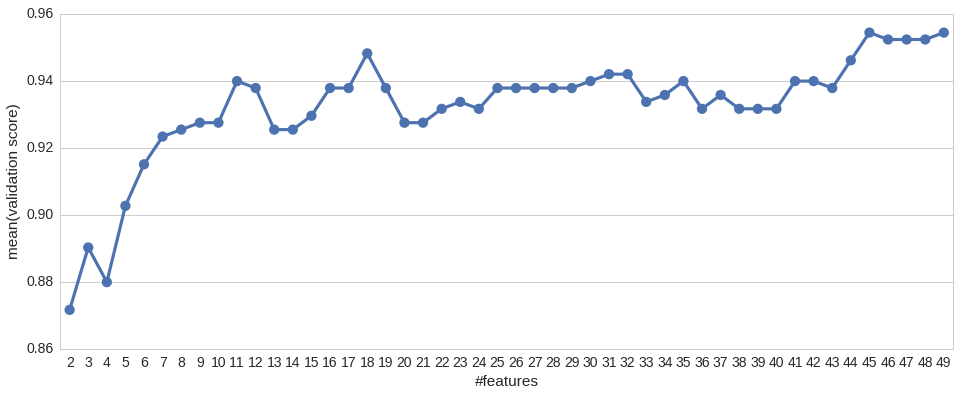

In [13]:
X = dataset.copy()
y = X.pop('label')

np.random.seed(123)
folds = np.random.randint(0,3,len(dataset))

Xtrain = X[folds==0]
Xtest = X[folds==1]
Xval = X[folds==2]
ytrain = y[folds==0]
ytest = y[folds==1]
yval = y[folds==2]

validation_scores = []
for k in range(2,50):
    svc.fit(Xtrain[importances_rank[0:k]],ytrain)
    validation_scores.append(roc_auc_score(yval,svc.decision_function(Xval[importances_rank[0:k]])))
    
pd_val_scores = pd.DataFrame()
pd_val_scores['#features'] = range(2,50)
pd_val_scores['validation score'] = validation_scores

plt.figure(figsize=(16,6))
sns.pointplot(x="#features", y="validation score", data=pd_val_scores)
plt.show()

- Is this score also achieved on the test set?

In [14]:
X = dataset.copy()
y = X.pop('label')

Xtrain = X[folds!=2]
ytrain = y[folds!=2]

svc.fit(Xtrain[importances_rank[0:11]],ytrain)
print "AUC on test set (top-11): %.2f" % roc_auc_score(ytest,svc.decision_function(Xtest[importances_rank[0:11]]))

AUC on test set (top-11): 0.91
